# Backtesting (backtrader)

In [1]:
import keras

import sys

sys.path.append('.')

import os
import datetime
import numpy as np
import pandas as pd

from datetime import datetime

np.random.seed(7)

from mikasa.strategy import Strategy
from mikasa.event import SignalEvent, OrderEvent
from mikasa.backtest import Backtest
from mikasa.data import HistoricCSVDataHandler
from mikasa.portfolio import NaivePortfolio
from mikasa.execution import SimulatedExecutionHandler

from sklearn.preprocessing import StandardScaler

import backtrader as bt

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

Using TensorFlow backend.


In [5]:
class PredictStrategy(bt.Strategy):
    TILT = 0.001

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.symbol = 'BTC_ETH'

        self.lag = 12
        csv_dir = './datasets/5min/'

        df = pd.read_csv(os.path.join(csv_dir, self.symbol + '_train.csv'))
        for lag in range(1, self.lag + 1):
            df['close-' + str(lag)] = df['close'] - df.shift(lag)['close']
        df.dropna(inplace=True)

        self.close_fields = ['close-{}'.format(i + 1) for i in range(self.lag)]

        df['up'] = df['close'] < df.shift(-1)['close']

        self.scaler = StandardScaler()
        X = df[self.close_fields].values
        self.scaler.fit(X)

        self.model = keras.models.load_model('model_5min_btc_eth.h5')

    def next(self):
        if len(self) > self.lag:
            X = [self.dataclose[n] for n in range(-self.lag, 1)]
            df = pd.DataFrame(X, columns=['close',])
            for lag in range(1, self.lag + 1):
                df['close-' + str(lag)] = df['close'] - df.shift(lag)['close']
            df.dropna(inplace=True)
            X = df[self.close_fields].values
            X = self.scaler.transform(X)
            prediction = self.model.predict(X)[0]
            if prediction[1] > 0.7:
                if not self.position:
                    self.buy(size=1.0)
            if prediction[0] > 0.7:
                if self.position:
                    self.sell(size=1.0)

In [6]:
cerebro = bt.Cerebro()
cerebro.addstrategy(PredictStrategy)

datapath = os.path.join('./datasets/5min/BTC_ETH_test.csv')

data = bt.feeds.GenericCSVData(
        dataname=datapath,
        dtformat=1, # timestamp second
        time=-1, # no column
        openinterest=-1 # no column
)

cerebro.adddata(data)
cerebro.broker.setcash(1.0)
cerebro.broker.setcommission(commission=0.002)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1.00
Final Portfolio Value: 0.98


/home/vampire/PycharmProjects/spbpy_meetup_10102017/venv/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


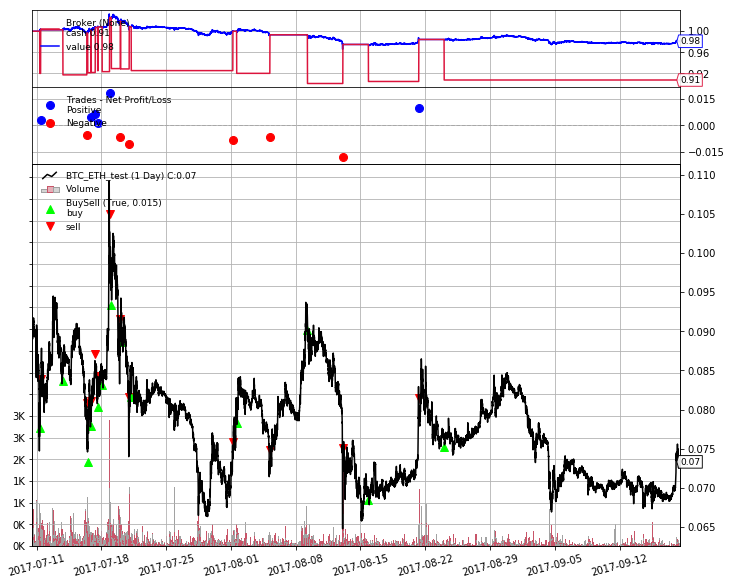

In [7]:
cerebro.plot();